In [10]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU')

True
NVIDIA GeForce RTX 4070 SUPER


# for tqdm warning
conda install -c conda-forge ipywidgets jupyterlab

In [ ]:
pip install transformers

In [ ]:
pip install sentence-transformers

In [ ]:
pip install hf_xet

In [4]:
import os
import random
import json
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
from PIL import Image, ImageDraw, ImageFilter

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
import torchvision.transforms.functional as TF

# NLP
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm

# -------------------------#
# Config
# -------------------------#
BASE_DIR = Path("./cv_with_llm_pipeline")
DATA_DIR = BASE_DIR / "data"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = 256
NUM_TRAIN = 200
NUM_VAL = 50
BATCH_SIZE = 4
NUM_CLASSES = 3  # background + intruder + vehicle

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# -------------------------#
# Synthetic dataset helpers
# -------------------------#
def make_surveillance_image(with_objects: List[Tuple[str, Tuple[int,int,int,int]]], size=IMG_SIZE):
    bg_color = (random.randint(30,200), random.randint(30,200), random.randint(30,200))
    img = Image.new("RGB", (size, size), color=bg_color)
    draw = ImageDraw.Draw(img)
    for label, (x1, y1, x2, y2) in with_objects:
        color = (200,30,30) if label=='intruder' else (30,30,200)
        if label == 'intruder':
            draw.ellipse([x1,y1,x2,y2], fill=color)
        else:
            draw.rectangle([x1,y1,x2,y2], fill=color)
    if random.random() < 0.4:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0,1.6)))
    arr = np.array(img).astype(np.uint8)
    noise = (np.random.randn(*arr.shape) * random.uniform(0,10)).astype(np.int32)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def random_bbox(size=IMG_SIZE, min_size=24, max_size=100):
    w = random.randint(min_size, max_size)
    h = random.randint(min_size, max_size)
    x1 = random.randint(0, size - w - 1)
    y1 = random.randint(0, size - h - 1)
    return (x1, y1, x1 + w, y1 + h)

def generate_synthetic_dataset(out_dir: Path, n_images=200, seed=42, save_empty_dir: Path=None):
    random.seed(seed)
    np.random.seed(seed)
    out_dir.mkdir(parents=True, exist_ok=True)
    if save_empty_dir:
        save_empty_dir.mkdir(parents=True, exist_ok=True)

    annotations = {}
    empty_count = 0

    for i in range(n_images):
        num_obj = random.choices([0,1,2,3], weights=[0.05,0.6,0.25,0.1], k=1)[0]
        objs, boxes, labels = [], [], []

        for _ in range(num_obj):
            label = random.choice(['intruder','vehicle'])
            bbox = random_bbox(size=IMG_SIZE, min_size=28, max_size=120)
            objs.append((label, bbox))
            boxes.append(list(bbox))
            labels.append(1 if label=='intruder' else 2)

        img = make_surveillance_image(objs, size=IMG_SIZE)
        fname = f"img_{i:04d}.png"

        if num_obj == 0:
            empty_count += 1
            if save_empty_dir:
                img.save(save_empty_dir / fname)
            continue  # skip empty image in main dataset to avoid errors

        img.save(out_dir / fname)
        annotations[fname] = {"boxes": boxes, "labels": labels}

    print(f"Generated {len(annotations)} valid images, skipped {empty_count} empty images.")
    return annotations

# -------------------------#
# Dataset class
# -------------------------#
class DetectionDataset(Dataset):
    def __init__(self, root: Path, annotations: Dict[str, Dict], transforms=None):
        self.annotations = {k:v for k,v in annotations.items() if len(v['labels'])>0}
        self.imgs = sorted(list(self.annotations.keys()))
        self.root = root
        self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        fn = self.imgs[idx]
        img_path = self.root / fn
        img = Image.open(img_path).convert("RGB")

        boxes = torch.tensor(self.annotations[fn]["boxes"], dtype=torch.float32)
        labels = torch.tensor(self.annotations[fn]["labels"], dtype=torch.int64)
        labels = torch.clamp(labels, min=1, max=NUM_CLASSES-1)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1]),
            "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

# -------------------------#
# Prepare datasets
# -------------------------#
if not (TRAIN_DIR.exists() and any(TRAIN_DIR.iterdir())):
    print("Generating TRAIN dataset...")
    train_ann = generate_synthetic_dataset(TRAIN_DIR, n_images=NUM_TRAIN, seed=1)
    
    print("Generating VAL dataset...")
    val_ann = generate_synthetic_dataset(VAL_DIR, n_images=NUM_VAL, seed=2)
    
    (BASE_DIR / "annotations").mkdir(exist_ok=True)
    with open(BASE_DIR / "annotations/train.json", "w") as f:
        json.dump(train_ann, f)
    with open(BASE_DIR / "annotations/val.json", "w") as f:
        json.dump(val_ann, f)
else:
    with open(BASE_DIR / "annotations/train.json") as f:
        train_ann = json.load(f)
    with open(BASE_DIR / "annotations/val.json") as f:
        val_ann = json.load(f)

def pil_to_tensor(img: Image.Image):
    return TF.to_tensor(img)

train_dataset = DetectionDataset(TRAIN_DIR, train_ann, transforms=pil_to_tensor)
val_dataset = DetectionDataset(VAL_DIR, val_ann, transforms=pil_to_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# -------------------------#
# Faster R-CNN model
# -------------------------#
def get_model(num_classes=NUM_CLASSES, pretrained=True):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT" if pretrained else None,
                                    weights_backbone="DEFAULT" if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_model(num_classes=NUM_CLASSES, pretrained=True)
model.to(DEVICE)
print("Model loaded and moved to device successfully.")


Device: cuda
Model loaded and moved to device successfully.


In [5]:
# -------------------------#
# NLP / LLM Setup
# -------------------------#
print("Loading NLP models...")
ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
sbert = SentenceTransformer('all-MiniLM-L6-v2')
llm_tokenizer = AutoTokenizer.from_pretrained("gpt2")
llm_model = AutoModelForCausalLM.from_pretrained("gpt2").to(DEVICE)

KB = [
    "Do not approach a suspected intruder. Alert security and record timestamps.",
    "If an unauthorized vehicle is detected in the loading bay, attempt automated license plate capture and notify operations.",
    "For perimeter breach, trigger loudspeaker warning and backup cameras to focus on the location.",
    "Always preserve video logs for 90 days and encrypt backups.",
    "Intruder detection false alarms often due to animals or lighting; verify with multiple cameras."
]
kb_embeddings = sbert.encode(KB, convert_to_numpy=True)

def retrieve_knowledge(query: str, topk=2):
    q_emb = sbert.encode([query], convert_to_numpy=True)
    sims = cosine_similarity(q_emb, kb_embeddings)[0]
    idxs = np.argsort(-sims)[:topk]
    return [KB[i] for i in idxs], [float(sims[i]) for i in idxs]

# -------------------------#
# Vision inference
# -------------------------#
def run_detector_on_image(model, pil_img: Image.Image, device=DEVICE, score_thresh=0.5):
    model.eval()
    img_tensor = TF.to_tensor(pil_img).to(device)
    with torch.no_grad():
        outputs = model([img_tensor])[0]
    boxes = outputs['boxes'].cpu().numpy()
    scores = outputs['scores'].cpu().numpy()
    labels = outputs['labels'].cpu().numpy()
    keep = scores >= score_thresh
    return [{"box": b.tolist(), "score": float(s), "label": int(l)} 
            for b,s,l in zip(boxes[keep], scores[keep], labels[keep])]

LABEL_MAP = {1:"intruder", 2:"vehicle"}

# -------------------------#
# Agentic reasoning loop
# -------------------------#
def agent_process_image_and_report(image_path: Path, textual_report: str = None):
    img = Image.open(image_path).convert("RGB")
    detections = run_detector_on_image(model, img, device=DEVICE, score_thresh=0.4)
    print("Detections:", detections)

    entities = ner_pipe(textual_report) if textual_report else []
    print("Entities:", entities)

    vision_summary = [f"{LABEL_MAP.get(d['label'],'obj')} at {tuple(map(int,d['box']))} score={d['score']:.2f}" for d in detections]
    vision_text = "; ".join(vision_summary) if vision_summary else "no objects detected"

    query = f"Vision: {vision_text}. Report entities: {entities}. What should security do?"
    kb_hits, sim_scores = retrieve_knowledge(query, topk=2)
    print("Retrieved KB items:", kb_hits, sim_scores)

    prompt = f"You are a security assistant.\nScene: {vision_text}\nRelevant procedures:\n- " + "\n- ".join(kb_hits) + "\nRecommended actions:"
    input_ids = llm_tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)
    out_ids = llm_model.generate(input_ids, max_length=input_ids.shape[1]+80, do_sample=True, temperature=0.7, top_p=0.9)
    out_text = llm_tokenizer.decode(out_ids[0][input_ids.shape[1]:], skip_special_tokens=True)
    print("LLM suggested actions:\n", out_text.strip())

    return {"detections": detections, "entities": entities, "kb": kb_hits, "llm": out_text.strip()}


print('no errors in code')

Loading NLP models...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


no errors in code


# Take 5 random images from the dataset to test

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Processing img_0007.png
Detections: [{'box': [10.448251724243164, 96.80631256103516, 143.23231506347656, 165.7941436767578], 'score': 0.7033497095108032, 'label': 1}, {'box': [73.39044952392578, 50.10558319091797, 115.47128295898438, 184.78689575195312], 'score': 0.5892035365104675, 'label': 1}, {'box': [0.0, 126.3464584350586, 176.9423065185547, 176.0060577392578], 'score': 0.5627003312110901, 'label': 1}, {'box': [28.394521713256836, 115.42130279541016, 118.61553192138672, 138.7908172607422], 'score': 0.5385037064552307, 'label': 1}, {'box': [0.0, 74.96979522705078, 176.357421875, 196.96987915039062], 'score': 0.5169897079467773, 'label': 1}, {'box': [0.0, 84.9955825805664, 159.2546844482422, 133.5892791748047], 'score': 0.5084878206253052, 'label': 1}, {'box': [3.0761570930480957, 88.3416976928711, 94.14826202392578, 193.0712127685547], 'score': 0.506409764289856, 'label': 1}, {'box': [42.8863525390625, 56.03474426269531, 123.4616928100586, 157.57211303710938], 'score': 0.497136294

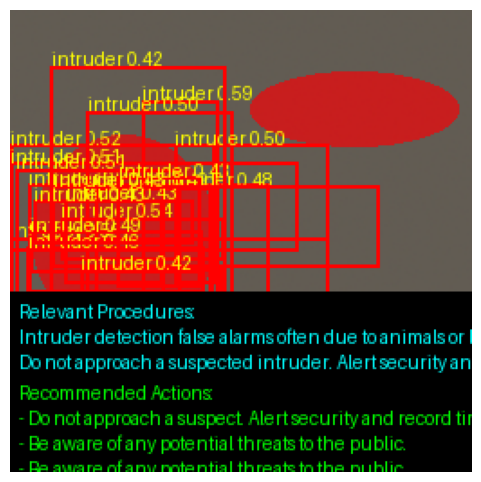

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Processing img_0026.png
Detections: [{'box': [133.8719940185547, 76.4706802368164, 215.1813201904297, 98.73306274414062], 'score': 0.45279476046562195, 'label': 1}, {'box': [129.64442443847656, 70.58453369140625, 215.56236267089844, 86.84666442871094], 'score': 0.44818657636642456, 'label': 1}, {'box': [118.98221588134766, 84.64722442626953, 224.92437744140625, 105.0418930053711], 'score': 0.44017523527145386, 'label': 1}, {'box': [208.2967987060547, 88.41577911376953, 253.03265380859375, 238.07766723632812], 'score': 0.4127238094806671, 'label': 1}, {'box': [162.0526580810547, 70.53408813476562, 204.63800048828125, 79.08655548095703], 'score': 0.412221223115921, 'label': 1}, {'box': [179.24273681640625, 133.6056671142578, 250.58261108398438, 228.52561950683594], 'score': 0.4078180193901062, 'label': 1}, {'box': [106.56776428222656, 72.04154968261719, 230.10476684570312, 111.33619689941406], 'score': 0.40162235498428345, 'label': 1}, {'box': [32.00307083129883, 141.34750366210938, 183

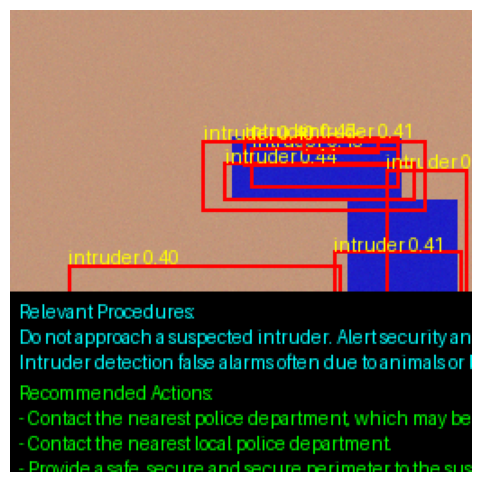

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Processing img_0020.png
Detections: [{'box': [0.0, 151.66213989257812, 158.14662170410156, 210.82354736328125], 'score': 0.49649059772491455, 'label': 1}, {'box': [72.54877471923828, 158.03353881835938, 117.7600326538086, 199.9650115966797], 'score': 0.4897274374961853, 'label': 1}, {'box': [36.05756378173828, 164.63548278808594, 127.91214752197266, 200.16946411132812], 'score': 0.4536131024360657, 'label': 1}, {'box': [53.29118347167969, 160.7599334716797, 114.44363403320312, 187.97637939453125], 'score': 0.45084211230278015, 'label': 1}, {'box': [11.054750442504883, 178.8534393310547, 131.78509521484375, 201.7871856689453], 'score': 0.43134140968322754, 'label': 1}, {'box': [56.31156921386719, 89.32213592529297, 231.64382934570312, 226.97711181640625], 'score': 0.42884233593940735, 'label': 1}, {'box': [87.65882873535156, 156.35623168945312, 130.47959899902344, 197.55723571777344], 'score': 0.42740556597709656, 'label': 1}, {'box': [10.326494216918945, 195.6925811767578, 126.9177627

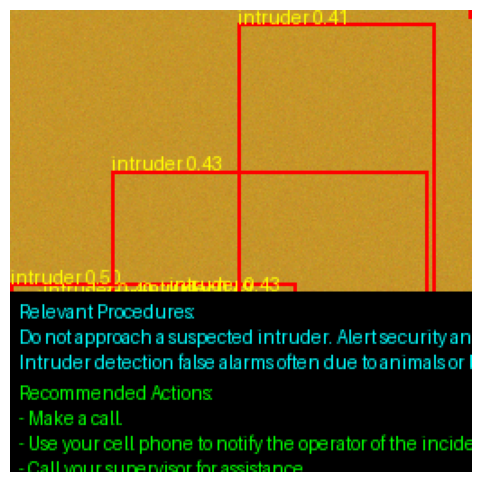

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Processing img_0043.png
Detections: [{'box': [102.19463348388672, 117.13312530517578, 173.61268615722656, 153.42391967773438], 'score': 0.5338720679283142, 'label': 1}, {'box': [124.2945785522461, 108.7796859741211, 163.7270050048828, 154.4188995361328], 'score': 0.5205121636390686, 'label': 1}, {'box': [114.65536499023438, 108.76602935791016, 199.81939697265625, 141.47189331054688], 'score': 0.517339825630188, 'label': 1}, {'box': [107.52596282958984, 110.79854583740234, 169.78794860839844, 135.87100219726562], 'score': 0.5013774037361145, 'label': 1}, {'box': [130.1754913330078, 113.32011413574219, 153.1202850341797, 142.41827392578125], 'score': 0.4918172359466553, 'label': 1}, {'box': [122.34721374511719, 117.32875061035156, 160.00494384765625, 136.97171020507812], 'score': 0.47303006052970886, 'label': 1}, {'box': [135.96690368652344, 118.69961547851562, 158.6322021484375, 145.16744995117188], 'score': 0.4572179913520813, 'label': 1}, {'box': [114.454345703125, 135.09259033203125

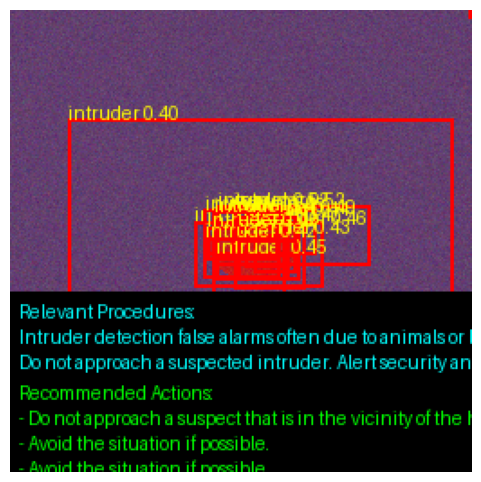

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Processing img_0010.png
Detections: [{'box': [184.59030151367188, 30.996829986572266, 256.0, 151.74742126464844], 'score': 0.6222236752510071, 'label': 1}, {'box': [172.65194702148438, 49.713523864746094, 256.0, 112.2643814086914], 'score': 0.6141215562820435, 'label': 1}, {'box': [160.05068969726562, 69.22160339355469, 232.7406768798828, 94.1618423461914], 'score': 0.5653702616691589, 'label': 1}, {'box': [158.3476104736328, 78.79490661621094, 256.0, 145.64173889160156], 'score': 0.5601149201393127, 'label': 1}, {'box': [165.7283172607422, 58.97262954711914, 218.470458984375, 129.97628784179688], 'score': 0.540995717048645, 'label': 1}, {'box': [154.27566528320312, 79.29253387451172, 235.4069061279297, 105.97931671142578], 'score': 0.535159707069397, 'label': 1}, {'box': [196.8244171142578, 0.0, 242.86390686035156, 137.2493438720703], 'score': 0.5317010283470154, 'label': 1}, {'box': [160.3527069091797, 35.98016357421875, 227.10720825195312, 174.58453369140625], 'score': 0.5246622562

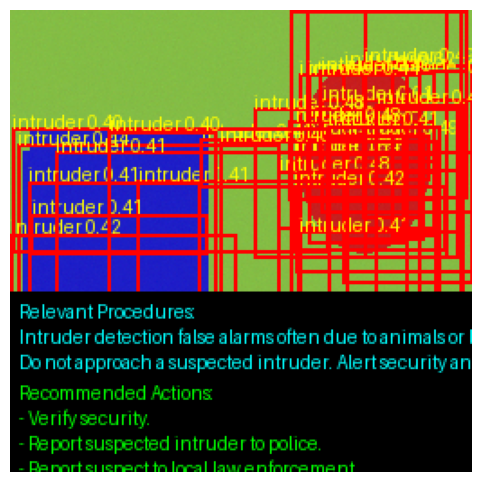

In [9]:
import random
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

REPORT_DIR = BASE_DIR / "reports_test"
REPORT_DIR.mkdir(exist_ok=True)

# Optional: load a default font
try:
    font = ImageFont.load_default()
except:
    font = None

# Pick only valid, annotated images otherwise there will be device assert error
valid_imgs = [p for p in VAL_DIR.glob("*.png") if p.name in val_ann]

# pick 5 random samples
sample_imgs = random.sample(valid_imgs, k=min(5, len(valid_imgs)))  

for img_path in sample_imgs:
    print(f"\nProcessing {img_path.name}")

    # Run agent loop safely with CUDA fallback
    try:
        result = agent_process_image_and_report(img_path)
    except RuntimeError as e:
        if "CUDA error" in str(e):
            print("CUDA assert detected! Falling back to CPU for this image.")
            tmp_device = DEVICE
            DEVICE = torch.device("cpu")
            result = agent_process_image_and_report(img_path)
            DEVICE = tmp_device
        else:
            raise e

    # Open image for annotation
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # Draw detected objects
    for det in result["detections"]:
        box = det["box"]
        label = LABEL_MAP.get(det["label"], "obj")
        score = det["score"]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]-10), f"{label} {score:.2f}", fill="yellow", font=font)

    # Overlay KB hits and LLM recommendations
    kb_text = "Relevant Procedures:\n" + "\n".join(result["kb"])
    llm_text = "Recommended Actions:\n" + result["llm"]

    # Draw background rectangle for text
    text_bg_height = 100
    draw.rectangle([0, IMG_SIZE-text_bg_height, IMG_SIZE, IMG_SIZE], fill=(0,0,0,200))
    draw.text((5, IMG_SIZE-95), kb_text, fill="cyan", font=font)
    draw.text((5, IMG_SIZE-50), llm_text, fill="lime", font=font)

    # Save annotated report image
    save_path = REPORT_DIR / f"report_{img_path.name}"
    img.save(save_path)
    print(f"Saved test report to {save_path}")

    # Display image inline
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# Test on whole dataset

In [7]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

REPORT_DIR = BASE_DIR / "reports"
REPORT_DIR.mkdir(exist_ok=True)

# Optional: load a default font
try:
    font = ImageFont.load_default()
except:
    font = None

# Pick only valid, annotated images
valid_imgs = [p for p in VAL_DIR.glob("*.png") if p.name in val_ann]

for img_path in valid_imgs:
    print(f"Processing {img_path.name}")

    # Run agent loop safely with CUDA fallback
    try:
        result = agent_process_image_and_report(img_path)
    except RuntimeError as e:
        if "CUDA error" in str(e):
            print("CUDA assert detected! Falling back to CPU for this image.")
            tmp_device = DEVICE
            DEVICE = torch.device("cpu")
            result = agent_process_image_and_report(img_path)
            DEVICE = tmp_device
        else:
            raise e

    # Open image for annotation
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    # Draw detected objects
    for det in result["detections"]:
        box = det["box"]
        label = LABEL_MAP.get(det["label"], "obj")
        score = det["score"]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]-10), f"{label} {score:.2f}", fill="yellow", font=font)

    # Overlay KB hits and LLM recommendations
    kb_text = "Relevant Procedures:\n" + "\n".join(result["kb"])
    llm_text = "Recommended Actions:\n" + result["llm"]

    # Draw background rectangle for text
    text_bg_height = 100
    draw.rectangle([0, IMG_SIZE-text_bg_height, IMG_SIZE, IMG_SIZE], fill=(0,0,0,200))
    draw.text((5, IMG_SIZE-95), kb_text, fill="cyan", font=font)
    draw.text((5, IMG_SIZE-50), llm_text, fill="lime", font=font)

    # Save annotated report image
    save_path = REPORT_DIR / f"report_{img_path.name}"
    img.save(save_path)
    print(f"Saved report to {save_path}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Processing img_0000.png
Detections: [{'box': [97.57960510253906, 165.88121032714844, 246.47816467285156, 234.4091339111328], 'score': 0.5708637237548828, 'label': 1}, {'box': [59.518890380859375, 155.18739318847656, 201.4027557373047, 252.07395935058594], 'score': 0.5509085655212402, 'label': 1}, {'box': [138.09588623046875, 129.99224853515625, 210.2637481689453, 234.8186798095703], 'score': 0.5296760201454163, 'label': 1}, {'box': [89.78440856933594, 184.69366455078125, 186.7410888671875, 250.4722137451172], 'score': 0.527294397354126, 'label': 1}, {'box': [152.6923370361328, 154.46914672851562, 246.31292724609375, 215.936767578125], 'score': 0.494491845369339, 'label': 1}, {'box': [93.13802337646484, 135.85488891601562, 250.3049774169922, 215.224609375], 'score': 0.49135780334472656, 'label': 1}, {'box': [97.658203125, 211.29400634765625, 173.4344482421875, 243.99563598632812], 'score': 0.47233837842941284, 'label': 1}, {'box': [85.23709106445312, 197.46722412109375, 223.789901733398

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Stay alert during daylight hours.
- Don't approach a suspect. Alert security and record timestamps.
- Avoid looking at the camera.
- Don't approach a suspect. Alert security and record timestamps.
- Do not approach a suspect. Alert security and record timestamps.
- Do not approach a suspect. Alert security and record timestamps.
Saved report to cv_with_llm_pipeline\reports\report_img_0000.png
Processing img_0001.png
Detections: [{'box': [89.44294738769531, 86.98148345947266, 176.99801635742188, 110.57687377929688], 'score': 0.4680419862270355, 'label': 1}, {'box': [84.46466827392578, 107.6078872680664, 247.90399169921875, 162.4412841796875], 'score': 0.4628191888332367, 'label': 1}, {'box': [32.575965881347656, 50.390350341796875, 199.90304565429688, 111.22570037841797], 'score': 0.4540856182575226, 'label': 1}, {'box': [160.23477172851562, 116.1895751953125, 183.1453094482422, 188.6924591064453], 'score': 0.4356616735458374, 'label': 1}, {'box': [20.951259613

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Ensure all devices have a sufficient distance to prevent an intruder from entering your home.
- Use a secure perimeter door.
- Do not approach a suspect who is attempting to enter your home.
- Do not approach a suspect who has a firearm or other weapon.
- Do not approach a suspect who has been found with a firearm or other weapon.
- Do not approach a
Saved report to cv_with_llm_pipeline\reports\report_img_0001.png
Processing img_0002.png
Detections: [{'box': [158.27102661132812, 80.27640533447266, 235.4869842529297, 193.16412353515625], 'score': 0.6478568315505981, 'label': 1}, {'box': [119.33332061767578, 102.99955749511719, 247.20518493652344, 186.93003845214844], 'score': 0.5699291229248047, 'label': 1}, {'box': [183.57310485839844, 92.77073669433594, 213.468994140625, 162.20936584472656], 'score': 0.476260244846344, 'label': 1}, {'box': [149.7987823486328, 50.92396545410156, 249.57061767578125, 155.59336853027344], 'score': 0.46691396832466125, 'label': 1}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Stay on the ground, preferably with a flashlight and be ready to respond if an intruder is approaching.
- Do not attempt to break through a window, window rack or other barrier, especially if the intruder is a human.
- Do not attempt to climb a fence or other obstacle.
- Do not attempt to cross a barrier or other barrier without the knowledge of the intruders.
Saved report to cv_with_llm_pipeline\reports\report_img_0002.png
Processing img_0003.png
Detections: [{'box': [253.74658203125, 138.71424865722656, 255.90403747558594, 149.50767517089844], 'score': 0.4742487668991089, 'label': 1}, {'box': [254.18182373046875, 146.01722717285156, 255.94300842285156, 150.87594604492188], 'score': 0.4719688296318054, 'label': 1}, {'box': [254.7057342529297, 62.91587829589844, 255.9390106201172, 68.24272155761719], 'score': 0.4597201943397522, 'label': 1}, {'box': [253.6293182373047, 62.57018280029297, 255.85142517089844, 73.41911315917969], 'score': 0.45735910534858704, 'la

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Check with animal control at (253, 128, 255, 150) score=0.43; call for assistance from animal control at (254, 128, 255, 150) score=0.43; call for assistance from animal control at (254, 128, 255, 150) score=0.43; call for assistance from animal control at (254, 128, 255,
Saved report to cv_with_llm_pipeline\reports\report_img_0003.png
Processing img_0004.png
Detections: [{'box': [166.85507202148438, 137.80307006835938, 242.2323760986328, 222.84503173828125], 'score': 0.4942339360713959, 'label': 1}, {'box': [149.5640411376953, 177.60400390625, 238.66004943847656, 209.32919311523438], 'score': 0.4514780640602112, 'label': 1}, {'box': [169.4676513671875, 163.90394592285156, 225.12550354003906, 212.42893981933594], 'score': 0.42716681957244873, 'label': 1}, {'box': [203.050048828125, 158.7530059814453, 229.67947387695312, 221.18019104003906], 'score': 0.4202560782432556, 'label': 1}, {'box': [254.02967834472656, 0.15914367139339447, 255.92135620117188, 4.6831421

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Hold a safe-exit for the intruder to prevent further intruders from entering the area.
- Avoid touching the intruder's hands or feet.
- Avoid touching the intruder's head.
- Make a safe-exit to a designated area.
- Hold the intruder for at least 10 minutes.
- Follow-up security procedures and follow through with the initial perimeter check.
Saved report to cv_with_llm_pipeline\reports\report_img_0004.png
Processing img_0005.png
Detections: [{'box': [69.347412109375, 182.05227661132812, 195.55751037597656, 237.36614990234375], 'score': 0.4720304012298584, 'label': 1}, {'box': [145.43222045898438, 188.7929229736328, 168.00425720214844, 252.1199188232422], 'score': 0.46338337659835815, 'label': 1}, {'box': [94.10964965820312, 174.2745819091797, 169.09088134765625, 253.98326110839844], 'score': 0.4246576726436615, 'label': 1}, {'box': [64.6088638305664, 210.79217529296875, 163.68389892578125, 241.10574340820312], 'score': 0.40349793434143066, 'label': 1}]
Entities

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Verify the timing of any potential intruders by using multiple cameras.
- Be aware of your surroundings and be aware of your surroundings and your surroundings.
- Be aware of the length of time you may be in a safe area.
- Be aware of your surroundings.
- Do not approach a suspect until the suspect has been subdued and is no longer in a safe area.
Saved report to cv_with_llm_pipeline\reports\report_img_0005.png
Processing img_0006.png
Detections: [{'box': [85.6114730834961, 157.0619659423828, 238.713623046875, 244.05255126953125], 'score': 0.586471676826477, 'label': 1}, {'box': [119.13095092773438, 151.63616943359375, 198.5823974609375, 253.1922607421875], 'score': 0.4966535270214081, 'label': 1}, {'box': [95.97066497802734, 185.52218627929688, 181.73243713378906, 212.07948303222656], 'score': 0.49303093552589417, 'label': 1}, {'box': [111.92903900146484, 218.60731506347656, 212.5516815185547, 248.85430908203125], 'score': 0.4750818610191345, 'label': 1}, {'b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Stay away from the suspect, or you may have to turn the camera off.
- Remove any other cameras.
- Don't approach a suspect.
- Make sure the victim has already been notified of your presence.
- Provide a safe and secure location.
- Stay away from any potential intruder or intruders.
- Keep your home and personal belongings in a secure place
Saved report to cv_with_llm_pipeline\reports\report_img_0006.png
Processing img_0007.png
Detections: [{'box': [10.448251724243164, 96.80631256103516, 143.23231506347656, 165.7941436767578], 'score': 0.7033497095108032, 'label': 1}, {'box': [73.39044952392578, 50.10558319091797, 115.47128295898438, 184.78689575195312], 'score': 0.5892035365104675, 'label': 1}, {'box': [0.0, 126.3464584350586, 176.9423065185547, 176.0060577392578], 'score': 0.5627003312110901, 'label': 1}, {'box': [28.394521713256836, 115.42130279541016, 118.61553192138672, 138.7908172607422], 'score': 0.5385037064552307, 'label': 1}, {'box': [0.0, 74.96979522

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Report any suspicious activity.
- Report any suspicious activity to the police, fire, or EMS.
- Report any suspicious activity to the city police.
- Report any suspicious activity to the local sheriff's department.
- Report any suspicious activity to the police and fire departments.
- Report any suspicious activity to the city fire department.
- Report any suspicious activity to the local
Saved report to cv_with_llm_pipeline\reports\report_img_0007.png
Processing img_0008.png
Detections: [{'box': [96.66629791259766, 15.907768249511719, 135.14895629882812, 125.59406280517578], 'score': 0.564459502696991, 'label': 1}, {'box': [91.67192840576172, 72.64266204833984, 152.01856994628906, 100.41188049316406], 'score': 0.5572949051856995, 'label': 1}, {'box': [109.15265655517578, 35.368255615234375, 129.23614501953125, 125.36714935302734], 'score': 0.5558051466941833, 'label': 1}, {'box': [65.85488891601562, 15.59935474395752, 133.6466522216797, 110.5412368774414], 's

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Report to the local police department.
- Report to the local authorities.
- Report to the local police department for assistance.
- Report to the local authorities for assistance.
- Report to the local authorities for assistance.
- Report to the local authorities for assistance.
- Report to the local authorities for assistance.
- Report to the local authorities for assistance.
-
Saved report to cv_with_llm_pipeline\reports\report_img_0008.png
Processing img_0009.png
Detections: [{'box': [180.83538818359375, 0.0, 245.2802734375, 91.87120819091797], 'score': 0.6246330738067627, 'label': 1}, {'box': [165.3503875732422, 44.524208068847656, 251.34835815429688, 67.0569839477539], 'score': 0.6174043416976929, 'label': 1}, {'box': [200.27723693847656, 13.760966300964355, 230.8468475341797, 101.20841217041016], 'score': 0.5595753192901611, 'label': 1}, {'box': [170.9715576171875, 49.715126037597656, 251.51780700683594, 78.71578979492188], 'score': 0.5461196899414062, '

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Avoid contact with the person who is injured or threatened.
- Take care to not provoke the person.
- Do not threaten the person.
- Do not approach the person.
- If possible, call 911.
- Do not use force on a suspect.
- Do not approach or approach a suspect.
- Do not use force on a suspect or others.
Saved report to cv_with_llm_pipeline\reports\report_img_0009.png
Processing img_0010.png
Detections: [{'box': [184.59030151367188, 30.996829986572266, 256.0, 151.74742126464844], 'score': 0.6222236752510071, 'label': 1}, {'box': [172.65194702148438, 49.713523864746094, 256.0, 112.2643814086914], 'score': 0.6141215562820435, 'label': 1}, {'box': [160.05068969726562, 69.22160339355469, 232.7406768798828, 94.1618423461914], 'score': 0.5653702616691589, 'label': 1}, {'box': [158.3476104736328, 78.79490661621094, 256.0, 145.64173889160156], 'score': 0.5601149201393127, 'label': 1}, {'box': [165.7283172607422, 58.97262954711914, 218.470458984375, 129.97628784179688], 'sc

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Identify, search, and identify a suspect.
- Identify and search for suspects.
- Stay alert.
- Keep an eye on neighbors and security personnel, especially at night.
- Use a flashlight to identify suspects.
- Use a flashlight to identify suspected intruders.
- Be proactive.
- Make sure all other residents are safe.
- Report suspected
Saved report to cv_with_llm_pipeline\reports\report_img_0010.png
Processing img_0011.png
Detections: [{'box': [103.01556396484375, 107.94281005859375, 231.75357055664062, 243.4951934814453], 'score': 0.7119288444519043, 'label': 1}, {'box': [126.74927520751953, 146.55039978027344, 210.75119018554688, 242.0687255859375], 'score': 0.6721508502960205, 'label': 1}, {'box': [113.07572174072266, 129.7497100830078, 185.311767578125, 256.0], 'score': 0.5745866298675537, 'label': 1}, {'box': [87.72537994384766, 150.00538635253906, 171.2565155029297, 237.5625], 'score': 0.5657440423965454, 'label': 1}, {'box': [170.00965881347656, 138.0700988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Be vigilant, be prepared, and be alert for any potential threat.
- Make sure your dog has a leash.
- Do not be alarmed when an intruder appears, and don't let your dog get into trouble.
- Do not approach a suspect who is not a security assistant.
- Do not approach the suspect if he is a new person, or a person with a
Saved report to cv_with_llm_pipeline\reports\report_img_0011.png
Processing img_0012.png
Detections: [{'box': [249.51817321777344, 35.227684020996094, 255.49044799804688, 64.59835815429688], 'score': 0.4752456843852997, 'label': 1}, {'box': [246.18914794921875, 35.180381774902344, 255.16387939453125, 46.50751495361328], 'score': 0.4684627056121826, 'label': 1}, {'box': [245.80813598632812, 38.73277282714844, 255.31607055664062, 71.68049621582031], 'score': 0.45789089798927307, 'label': 1}, {'box': [245.95999145507812, 54.91676712036133, 255.38800048828125, 66.57707977294922], 'score': 0.4569443464279175, 'label': 1}, {'box': [254.63755798339844, 5

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
- Open the door. Do not enter.
Saved report to cv_with_llm_pipeline\reports\report_img_0012.png
Processing img_0013.png
Detections: [{'box': [198.40313720703125, 101.93388366699219, 254.7152862548828, 175.10552978515625], 'score': 0.56895512342453, 'label': 1}, {'box': [182.5599365234375, 122.75479888916016, 256.0, 163.32785034179688], 'score': 0.5233350992202759, 'label': 1}, {'box': [210.37518310546875, 116.12374877929688, 245.50128173828125, 157.78453063964844], 'score': 0.515903651714325, 'label': 1}, {'box': [186.2240753173828, 138.29978942871094, 256.0, 171.17166137695312], 'score': 0.5150725245475769, 'label': 1}, {'box': [191.2604217529297, 111.4286117553711, 246.6724090576172, 139.561279296875], 'score': 0.4587497115135193, 'label': 1}, {'b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Open an investigation and alert the nearest police officer.
- Investigate the incident.
- Conduct a thorough investigation.
- Take action if necessary to prevent an incident.
- Do not attempt to enter or exit a dwelling or apartment building or any other property.
- Report an intruder's location.
- Call 911 to report an intruder.
- Call 911 to report an
Saved report to cv_with_llm_pipeline\reports\report_img_0013.png
Processing img_0014.png
Detections: [{'box': [108.61746978759766, 103.63204956054688, 162.43386840820312, 133.75741577148438], 'score': 0.5880675911903381, 'label': 1}, {'box': [98.72991943359375, 107.79741668701172, 152.7880859375, 143.44236755371094], 'score': 0.5279067158699036, 'label': 1}, {'box': [98.15287780761719, 114.77237701416016, 195.35499572753906, 138.2404327392578], 'score': 0.5115306973457336, 'label': 1}, {'box': [118.79380798339844, 104.6891098022461, 143.9775390625, 137.68026733398438], 'score': 0.508085310459137, 'label': 1}, {

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Monitor for any possible threat.
- Monitor for any possible intruder.
- Provide verbal and written warnings.
- Report any possible threat to the public.
- Check to make sure the intruder is not using the Internet.
- Provide the following information:
- A description of the suspect.
- A description of the suspect's home.
- The name of the suspect
Saved report to cv_with_llm_pipeline\reports\report_img_0014.png
Processing img_0015.png
Detections: [{'box': [51.824222564697266, 8.985921859741211, 143.84454345703125, 45.021400451660156], 'score': 0.5940874814987183, 'label': 1}, {'box': [86.34107971191406, 2.943410634994507, 115.61446380615234, 49.850135803222656], 'score': 0.5241534113883972, 'label': 1}, {'box': [50.49019241333008, 4.202258110046387, 136.95068359375, 28.229007720947266], 'score': 0.5059358477592468, 'label': 1}, {'box': [46.59007263183594, 28.638328552246094, 134.46311950683594, 50.82077407836914], 'score': 0.5036901235580444, 'label': 1}, {'box'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Report suspected intruders to the police; alert officers and staff to incidents of potential intruders.
- Monitor officers for any changes in the alarm and recording frequency.
- Report suspicious activity to the department's police department.
- Report suspected intruders to the public.
- Report suspected intruders to the police if they have a prior report of a suspected intruder.
- Report
Saved report to cv_with_llm_pipeline\reports\report_img_0015.png
Processing img_0016.png
Detections: [{'box': [163.0581817626953, 54.19519805908203, 237.15806579589844, 159.29962158203125], 'score': 0.653952956199646, 'label': 1}, {'box': [124.12916564941406, 0.0, 251.09585571289062, 171.961669921875], 'score': 0.6416040658950806, 'label': 1}, {'box': [107.57875061035156, 39.64387512207031, 225.94058227539062, 126.06918334960938], 'score': 0.5622557401657104, 'label': 1}, {'box': [148.4745635986328, 12.285595893859863, 236.91761779785156, 130.65646362304688], 'score': 0.559

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Open a secure room.
- Call the police.
- Open a safe room.
- Call the sheriff.
- Open a door.
- Call the security team.
- Call the FBI.
- Call the police.
- Call the police.
- Call the police.
- Call the police.
- Call the police.
- Call the police
Saved report to cv_with_llm_pipeline\reports\report_img_0016.png
Processing img_0017.png
Detections: [{'box': [83.0525894165039, 50.74558639526367, 123.60133361816406, 98.04290008544922], 'score': 0.5375642776489258, 'label': 1}, {'box': [72.17961120605469, 51.60408020019531, 130.65289306640625, 74.9234390258789], 'score': 0.47686389088630676, 'label': 1}, {'box': [92.14531707763672, 41.85066223144531, 117.56746673583984, 86.2313232421875], 'score': 0.4436405897140503, 'label': 1}, {'box': [104.71829223632812, 55.38618850708008, 117.50601959228516, 87.96896362304688], 'score': 0.43230292201042175, 'label': 1}, {'box': [78.1175537109375, 55.79018020629883, 107.85227966308594, 98.19651794433594], 'score': 0.4222975373

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Ensure all officers are aware of the intruder and the presence of animals.
- Call for assistance.
- Report to the department.
- Contact a supervisor.
- Report to the department's Police Complaint Review Board.
- Report to the Department's Special Investigations Division.
- Report to the Department's Child Support and Support Review Board.
- Report to the Department's
Saved report to cv_with_llm_pipeline\reports\report_img_0017.png
Processing img_0018.png
Detections: [{'box': [3.217155694961548, 92.18097686767578, 48.35322189331055, 152.11581420898438], 'score': 0.6394133567810059, 'label': 1}, {'box': [3.6819701194763184, 113.04510498046875, 43.84555435180664, 169.8187255859375], 'score': 0.6331079006195068, 'label': 1}, {'box': [0.0, 111.1138916015625, 55.14048767089844, 141.52935791015625], 'score': 0.5922788977622986, 'label': 1}, {'box': [17.987733840942383, 89.00537109375, 38.591064453125, 173.25782775878906], 'score': 0.5797537565231323, 'label': 1}, {'b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Remove the animal from the premises.
- Use the appropriate equipment to make an identification.
- Use a video camera or an advanced camera to verify the identification.
- Contact the police to report a suspicious animal.
- Contact the local fire department if possible.
- Inspect the premises for signs of tampering.
- Check the premises for any signs of tampering.
- Inspect
Saved report to cv_with_llm_pipeline\reports\report_img_0018.png
Processing img_0019.png
Detections: [{'box': [253.94674682617188, 0.20891280472278595, 255.92007446289062, 4.054595947265625], 'score': 0.4529151916503906, 'label': 1}, {'box': [51.764530181884766, 99.13058471679688, 182.0588836669922, 163.75958251953125], 'score': 0.44373297691345215, 'label': 1}, {'box': [0.0, 0.21711501479148865, 1.55965256690979, 4.4358744621276855], 'score': 0.4314202070236206, 'label': 1}, {'box': [29.74582862854004, 109.44075012207031, 233.6210174560547, 178.23300170898438], 'score': 0.41917335987091064,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Call the police if you are a suspect or suspect may be in possession of an illegal firearm.
- Call the police if you have been threatened with violence or to death by someone you know.
- Call the police if you have been threatened with violence or to death by someone you know.
- Call the police if you are a suspect or suspect may be in possession of a firearm
Saved report to cv_with_llm_pipeline\reports\report_img_0019.png
Processing img_0020.png
Detections: [{'box': [0.0, 151.66213989257812, 158.14662170410156, 210.82354736328125], 'score': 0.49649059772491455, 'label': 1}, {'box': [72.54877471923828, 158.03353881835938, 117.7600326538086, 199.9650115966797], 'score': 0.4897274374961853, 'label': 1}, {'box': [36.05756378173828, 164.63548278808594, 127.91214752197266, 200.16946411132812], 'score': 0.4536131024360657, 'label': 1}, {'box': [53.29118347167969, 160.7599334716797, 114.44363403320312, 187.97637939453125], 'score': 0.45084211230278015, 'label': 1}, {

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch, touch,
Saved report to cv_with_llm_pipeline\reports\report_img_0020.png
Processing img_0021.png
Detections: [{'box': [96.10487365722656, 129.22872924804688, 115.14736938476562, 198.0485076904297], 'score': 0.4835902452468872, 'label': 1}, {'box': [70.85302734375, 133.6670684814453, 119.90716552734375, 195.1912384033203], 'score': 0.4712965786457062, 'label': 1}, {'box': [69.81343078613281, 123.98326873779297, 108.21571350097656, 133.70205688476562], 'score': 0.4458906054496765, 'label': 1}, {'box': [254.14630126953125, 100.25596618652344, 255.9739990234375, 104.91910552978516], 'score': 0.4025377929210663, 'label': 1}, {'box': [73.43097686767578, 128.0338592529297, 111.45063018798828, 171.1431274414

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Ensure the intruder is not present or in danger before the perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter perimeter
Saved report to cv_with_llm_pipeline\reports\report_img_0021.png
Processing img_0022.png
Detections: [{'box': [151.41632080078125, 104.78324890136719, 216.40150451660156, 129.9645233154297], 'score': 0.7871609926223755, 'label': 1}, {'box': [157

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Keep all lights on the vehicle.
- Check for animals, lights, and other vehicle components.
- Check for any other signs of activity.
- Be alert for animals, lights, and other vehicle components.
- Inspect all vehicle components.
- Verify any other signs of activity.
- Do not approach an intruder.
- Do not approach any other vehicle components.
Saved report to cv_with_llm_pipeline\reports\report_img_0022.png
Processing img_0023.png
Detections: [{'box': [42.49390411376953, 93.7665786743164, 105.20226287841797, 221.0865936279297], 'score': 0.48665332794189453, 'label': 1}, {'box': [46.22561264038086, 129.50619506835938, 96.95366668701172, 187.16883850097656], 'score': 0.448366641998291, 'label': 1}, {'box': [56.87040328979492, 123.42292785644531, 84.3076171875, 199.8494873046875], 'score': 0.440202534198761, 'label': 1}, {'box': [254.05496215820312, 0.1842474341392517, 255.91729736328125, 4.736257076263428], 'score': 0.43567606806755066, 'label': 1}, {'box': [36.1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach a suspect outside the residence or at a public place, or in a public area, during an intruder investigation.
- Do not approach a suspect outside the residence or at a public place, or in a public area, during an intruder investigation. Do not attempt to apprehend the suspect.
- Do not approach a suspect outside the residence or at a public place, or in
Saved report to cv_with_llm_pipeline\reports\report_img_0023.png
Processing img_0024.png
Detections: [{'box': [196.20260620117188, 137.311279296875, 255.05238342285156, 168.9800567626953], 'score': 0.7114883661270142, 'label': 1}, {'box': [192.49563598632812, 119.02605438232422, 250.29806518554688, 213.1991424560547], 'score': 0.6726557016372681, 'label': 1}, {'box': [204.43333435058594, 144.67759704589844, 249.1644287109375, 201.6424102783203], 'score': 0.6283230781555176, 'label': 1}, {'box': [214.04644775390625, 101.2665786743164, 240.09878540039062, 205.50399780273438], 'score': 0.61562877893

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Check for the presence of a red or blue light.
- Call for help if possible.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call for assistance if necessary.
- Call
Saved report to cv_with_llm_pipeline\reports\report_img_0024.png
Processing img_0025.png
Detections: [{'box': [148.2674560546875, 38.282413482666016, 256.0, 109.171142578125], 'score': 0.6112003922462463, 'label': 1}, {'box': [185.9490966796875, 31.832792282104492, 221.93675231933594, 99.3427505493164], 'score': 0.4932076632976532, 'label': 1}, {'box': [200.01736450195312, 40.72359848022461, 228.59950256347656, 109.15403747558594], 'score': 0.49305129051208496, 'label': 1}, {'box': [161.50665283203125, 71.09465789794922, 243.3233184814453, 107.76876068115234], 'score': 0.47899603843688965, 'label': 1}, {'box': [190.33541870117188, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Determine whether a person is a suspect.
- Verify with multiple cameras.
- Determine whether a person is a suspect. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with multiple cameras. - Verify with
Saved report to cv_with_llm_pipeline\reports\report_img_0025.png
Processing img_0026.png
Detections: [{'box': [133.8719940185547, 76.4706802368164, 215.1813201904297, 98.73306274414062], 'score': 0.45279476046562195, 'label': 1}, {'box': [129.64442443847656, 70.58453369140625, 215.56236267089844, 86.84666442871094], 'score': 0.44818657636642456, 'label': 1}, {'box': [118.98221588134766, 84.64722442626953, 224.92437744140625, 105.0418930053711], 'score': 0.44017523527145386, 'label': 1}, {'box': [208.2967987060547, 88.41577911376953, 253.03265380859375, 238.07766723632812], 'score':

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach a suspect at all.
- Do not approach a suspect at all if the suspect is not physically present or has a history of being a danger to others.
- Do not approach a suspect in the presence of an intruder.
- Do not approach a suspect if the suspect is wearing a mask or otherwise exhibiting signs of a disguise.
- Do not approach a suspect
Saved report to cv_with_llm_pipeline\reports\report_img_0026.png
Processing img_0027.png
Detections: [{'box': [38.771873474121094, 98.12647247314453, 252.98887634277344, 149.71954345703125], 'score': 0.5987849235534668, 'label': 1}, {'box': [91.22859191894531, 117.58319854736328, 181.3337860107422, 139.62315368652344], 'score': 0.5648908615112305, 'label': 1}, {'box': [67.30496978759766, 113.49998474121094, 187.52381896972656, 129.07530212402344], 'score': 0.5155791640281677, 'label': 1}, {'box': [153.46817016601562, 110.65123748779297, 160.54080200195312, 118.73961639404297], 'score': 0.49565887451171875, 'label': 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Inform the victim that the intruder was present and that he/she is safe.
- Report the intruder's location and date of attack.
- Determine if the suspect is a person with whom the intruder has been in contact.
- Determine if the suspect is a potential threat to public safety.
- Determine if the suspect has any other information.
- Report the
Saved report to cv_with_llm_pipeline\reports\report_img_0027.png
Processing img_0028.png
Detections: [{'box': [106.93927764892578, 209.280517578125, 180.45755004882812, 243.93040466308594], 'score': 0.5462243556976318, 'label': 1}, {'box': [90.82404327392578, 226.0904998779297, 182.70225524902344, 248.73049926757812], 'score': 0.4663636386394501, 'label': 1}, {'box': [96.40999603271484, 209.82054138183594, 153.38925170898438, 230.8524627685547], 'score': 0.4591171145439148, 'label': 1}, {'box': [253.9396209716797, 0.21980498731136322, 255.90814208984375, 4.072697162628174], 'score': 0.4242047071456909, 'label': 1}, {'box': 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Open the door and wait for the intruders to enter.
- Verify and record timestamps and other relevant records.
- Make sure the intruder is a real person and does not move.
- Report the intruder to the police.
- Call the police to report the incident.
- Report the incident to the National Center for Missing and Exploited Children.
-
Saved report to cv_with_llm_pipeline\reports\report_img_0028.png
Processing img_0029.png
Detections: [{'box': [176.24916076660156, 104.48155975341797, 211.48141479492188, 239.13526916503906], 'score': 0.6817086338996887, 'label': 1}, {'box': [189.33924865722656, 112.41947174072266, 205.31491088867188, 228.52435302734375], 'score': 0.6451619863510132, 'label': 1}, {'box': [169.05764770507812, 140.7124786376953, 210.323974609375, 215.95372009277344], 'score': 0.6293193697929382, 'label': 1}, {'box': [169.8327178955078, 110.2353515625, 196.7552490234375, 234.84214782714844], 'score': 0.5676863193511963, 'label': 1}, {'box': [181.2385559

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach a suspected intruder. Alert security and record timestamps.
- Use a safe and secure location.
- Follow all applicable regulations.
- Do not attempt to use a controlled substance.
- Do not use a firearm.
- Do not attempt to use a weapon.
- Do not attempt to run from a suspect.
- Do not attempt to enter
Saved report to cv_with_llm_pipeline\reports\report_img_0029.png
Processing img_0030.png
Detections: [{'box': [132.2961883544922, 132.3578643798828, 214.66087341308594, 168.50770568847656], 'score': 0.5471488237380981, 'label': 1}, {'box': [156.09075927734375, 130.64599609375, 196.96205139160156, 166.3427276611328], 'score': 0.49279356002807617, 'label': 1}, {'box': [0.0, 0.2996380627155304, 1.9097143411636353, 4.209537506103516], 'score': 0.48421451449394226, 'label': 1}, {'box': [253.88604736328125, 0.07121413946151733, 255.93820190429688, 3.964175224304199], 'score': 0.46875086426734924, 'label': 1}, {'box': [129.86026000976562, 130.53553771972

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach the intruder.
- Do not approach any objects or persons in the area.
- Do not approach any objects or persons in the area.
- Do not approach any other property.
- Do not approach any other person.
- Do not approach any other person.
- Do not approach any other person.
- Do not approach any other person.
Saved report to cv_with_llm_pipeline\reports\report_img_0030.png
Processing img_0031.png
Detections: [{'box': [0.0, 32.97826385498047, 149.48475646972656, 86.9465103149414], 'score': 0.43723487854003906, 'label': 1}, {'box': [79.379150390625, 43.97198486328125, 100.44186401367188, 113.39657592773438], 'score': 0.4307502508163452, 'label': 1}, {'box': [20.86525535583496, 62.38798522949219, 101.17017364501953, 89.49977111816406], 'score': 0.4286983609199524, 'label': 1}, {'box': [0.0, 1.8962236642837524, 172.31698608398438, 18.430072784423828], 'score': 0.42795994877815247, 'label': 1}, {'box': [254.23593139648438, 0.25050291419029236, 255.93855285

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach a suspected intruder. Alert security and record timestamps.
- Do not approach a suspected intruder. Alert security and record timestamps.
- Do not approach a suspected intruder. Alert security and record timestamps.
- Do not approach a suspected intruder. Alert security and record timestamps.
- Do not approach a suspect. Alert security and record
Saved report to cv_with_llm_pipeline\reports\report_img_0031.png
Processing img_0032.png
Detections: [{'box': [121.28306579589844, 170.32769775390625, 249.3174285888672, 251.5252227783203], 'score': 0.6306381821632385, 'label': 1}, {'box': [68.52214813232422, 141.0024871826172, 144.988037109375, 167.7570343017578], 'score': 0.5245203375816345, 'label': 1}, {'box': [51.864227294921875, 84.77859497070312, 242.96725463867188, 193.6818389892578], 'score': 0.4900971055030823, 'label': 1}, {'box': [132.201904296875, 158.9091339111328, 208.58116149902344, 243.7350311279297], 'score': 0.47177326679229736, 'lab

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Make sure all animals are safe.
- Take a break from the scene.
- Stay at least 15 minutes.
- Avoid the area where the intruder entered the area.
- Stay within the boundaries of the area where the intruder entered.
- Avoid any buildings or areas that may be used as an entry point for the intruder.
- Stay within the perimeter of the area
Saved report to cv_with_llm_pipeline\reports\report_img_0032.png
Processing img_0033.png
Detections: [{'box': [54.06465148925781, 147.66856384277344, 137.66436767578125, 240.2826690673828], 'score': 0.47911572456359863, 'label': 1}, {'box': [84.46556091308594, 120.94466400146484, 130.50244140625, 250.9808807373047], 'score': 0.45518311858177185, 'label': 1}, {'box': [8.5839204788208, 229.28175354003906, 171.57574462890625, 243.12042236328125], 'score': 0.43130403757095337, 'label': 1}, {'box': [31.32545280456543, 146.45083618164062, 191.11636352539062, 201.20529174804688], 'score': 0.4290805160999298, 'label': 1}, {'box': [66.04

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Provide warning.
- Encourage security to alert.
- Protect the victim and the intruder from potential harm or injury.
- Provide additional protection to protect the victim and the intruder from potential harm or injury.
- Provide additional protection to protect the victim and the intruder from potential harm or injury.
- Provide additional protection to protect the victim and the intruder from potential harm or injury
Saved report to cv_with_llm_pipeline\reports\report_img_0033.png
Processing img_0034.png
Detections: [{'box': [11.696210861206055, 113.11820220947266, 196.48403930664062, 192.81472778320312], 'score': 0.7355684638023376, 'label': 1}, {'box': [44.46644973754883, 63.75777053833008, 175.17724609375, 201.307373046875], 'score': 0.6847863793373108, 'label': 1}, {'box': [79.61671447753906, 54.99180603027344, 146.3575897216797, 220.75823974609375], 'score': 0.6726760268211365, 'label': 1}, {'box': [30.991254806518555, 102.38617706298828, 142.40388488769

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Check for signs of an intruder.
- Contact the nearest police station for more information.
- Use a cell phone to call the nearest police station.
- Call 911 if an intruder is present.
- If an intruder is on the loose, call the nearest police station.
- Do not approach an intruder with a knife.
- Do not approach an intruder with a knife
Saved report to cv_with_llm_pipeline\reports\report_img_0034.png
Processing img_0035.png
Detections: [{'box': [218.0465545654297, 127.2502670288086, 256.0, 185.0431671142578], 'score': 0.6753316521644592, 'label': 1}, {'box': [219.72914123535156, 110.23606872558594, 254.46875, 164.8420867919922], 'score': 0.6064283847808838, 'label': 1}, {'box': [205.47959899902344, 117.54119110107422, 244.8201446533203, 202.91302490234375], 'score': 0.6012527346611023, 'label': 1}, {'box': [199.68521118164062, 131.04591369628906, 250.35568237304688, 159.85263061523438], 'score': 0.5834525227546692, 'label': 1}, {'box': [228.92718505859375, 93.7

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Verify and verify video surveillance, CCTV, and other video surveillance systems.
- Check the camera manual for any warnings or warnings that are inconsistent with your video surveillance.
- Ensure that the video surveillance system has been installed.
- Check your camera manual for any warnings or warnings that are inconsistent with your video surveillance.
- Verify your camera manual and check your security camera manual.
Saved report to cv_with_llm_pipeline\reports\report_img_0035.png
Processing img_0036.png
Detections: [{'box': [98.28038024902344, 157.07557678222656, 249.1764373779297, 209.5117950439453], 'score': 0.5228186249732971, 'label': 1}, {'box': [152.13351440429688, 167.90145874023438, 191.91366577148438, 204.16661071777344], 'score': 0.515091061592102, 'label': 1}, {'box': [125.4068603515625, 167.74966430664062, 198.25076293945312, 196.8187255859375], 'score': 0.49879804253578186, 'label': 1}, {'box': [108.11013793945312, 178.81886291503906, 198.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Check for any signs of light, including the presence of animal activity.
- Be alert to any animal activity that could be triggering alarms.
- Check for any other signs of light that could be triggering alarms.
- Be aware that the alarm is not working or is inoperative.
- Be aware that the alarm is not working or is inoperative.
- Make sure the
Saved report to cv_with_llm_pipeline\reports\report_img_0036.png
Processing img_0037.png
Detections: [{'box': [177.15394592285156, 96.30790710449219, 243.75393676757812, 206.8253631591797], 'score': 0.727624773979187, 'label': 1}, {'box': [148.78598022460938, 118.7685546875, 247.72671508789062, 190.4110565185547], 'score': 0.6890561580657959, 'label': 1}, {'box': [159.19439697265625, 134.73802185058594, 223.14224243164062, 163.2037811279297], 'score': 0.6302648186683655, 'label': 1}, {'box': [165.69390869140625, 119.65387725830078, 215.4043731689453, 201.29188537597656], 'score': 0.5950048565864563, 'label': 1}, {'box': 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not open or close doors;
- Avoid direct contact with an intruder;
- Check if any of the above steps have been taken before or after.
- Make sure that no more than one of the above steps has been taken before or after a potential intruder has been identified.
- Make sure that no other steps have been taken before or after a potential intruder has been identified
Saved report to cv_with_llm_pipeline\reports\report_img_0037.png
Processing img_0038.png
Detections: [{'box': [195.6943359375, 89.8041763305664, 253.24264526367188, 179.4430389404297], 'score': 0.46390286087989807, 'label': 1}, {'box': [156.9652862548828, 106.63021087646484, 254.04766845703125, 208.6619110107422], 'score': 0.46375057101249695, 'label': 1}, {'box': [168.38392639160156, 163.82150268554688, 252.81341552734375, 196.39134216308594], 'score': 0.4329482913017273, 'label': 1}, {'box': [172.706787109375, 115.44145202636719, 253.6944122314453, 166.78463745117188], 'score': 0.4092658460140228, 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Encourage security to avoid contact with an intruder or to notify authorities of an intruder's presence.
- Use a multi-camera camera to watch the suspect or witness and to keep an eye on the suspect.
- Stay alert to noise and to make sure there are no alarms.
- Provide a safe perimeter.
- Provide a safe perimeter to protect the person or property.
Saved report to cv_with_llm_pipeline\reports\report_img_0038.png
Processing img_0039.png
Detections: [{'box': [114.09156799316406, 145.04197692871094, 201.6600799560547, 178.1932830810547], 'score': 0.6167230010032654, 'label': 1}, {'box': [103.18949127197266, 113.09282684326172, 205.9135284423828, 215.37020874023438], 'score': 0.4908647835254669, 'label': 1}, {'box': [108.82203674316406, 159.75180053710938, 187.9384765625, 194.02821350097656], 'score': 0.46820786595344543, 'label': 1}, {'box': [134.5819549560547, 137.7998809814453, 175.16477966308594, 189.1506805419922], 'score': 0.4453660845756531, 'label': 1}, {'b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Record and record when a suspect is in the vicinity of the vehicle or the vehicle is moving.
- Record when a suspect is approaching the vehicle in a manner that is likely to cause a danger to others or to the public.
- Verify that a suspect is within the time allowed for the security and recording of the vehicle or the vehicle is moving.
- Report the location of the
Saved report to cv_with_llm_pipeline\reports\report_img_0039.png
Processing img_0040.png
Detections: [{'box': [253.84664916992188, 0.19065764546394348, 255.9023895263672, 4.173964500427246], 'score': 0.4396791160106659, 'label': 1}, {'box': [0.0, 0.3079022169113159, 1.7737592458724976, 4.681514263153076], 'score': 0.43063127994537354, 'label': 1}, {'box': [254.5437774658203, 0.46831390261650085, 255.938232421875, 8.318962097167969], 'score': 0.41243988275527954, 'label': 1}]
Entities: []
Retrieved KB items: ['Do not approach a suspected intruder. Alert security and record timestamps.', 'Intruder de

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Interaction with the intruder, check the intruder's ID, and inform the guard that the intruder is inside the home.
- Check for any potential signs of a burglary, such as a broken window or a broken door.
- Call the burglar's attorney to see if he has any witnesses.
- Call 911 and speak to the intruder's attorney.
- Call 911 and
Saved report to cv_with_llm_pipeline\reports\report_img_0040.png
Processing img_0041.png
Detections: [{'box': [65.8283920288086, 148.48049926757812, 154.688720703125, 236.19386291503906], 'score': 0.6220788359642029, 'label': 1}, {'box': [68.4105224609375, 179.96473693847656, 146.48568725585938, 215.52700805664062], 'score': 0.5607237815856934, 'label': 1}, {'box': [91.62754821777344, 155.6698760986328, 144.7920379638672, 210.16949462890625], 'score': 0.547289252281189, 'label': 1}, {'box': [94.7245864868164, 145.98397827148438, 125.09888458251953, 220.43194580078125], 'score': 0.5251444578170776, 'label': 1}, {'box': [65.49739837646484

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Determine if there are any physical clues or markings in the area.
- Verify if there is a security guard.
- Report any suspicious activity.
- Verify if there is any other sign that a threat has been detected.
- Report any suspicious activity.
- Report any suspicious activity.
- Report any suspicious activity.
- Report any suspicious activity.
- Report
Saved report to cv_with_llm_pipeline\reports\report_img_0041.png
Processing img_0042.png
Detections: [{'box': [109.702880859375, 97.66657257080078, 187.82179260253906, 128.19667053222656], 'score': 0.5192623138427734, 'label': 1}, {'box': [64.75239562988281, 66.76984405517578, 91.67916107177734, 137.0944366455078], 'score': 0.5066883563995361, 'label': 1}, {'box': [51.623626708984375, 64.32671356201172, 99.99042510986328, 121.47384643554688], 'score': 0.5065510869026184, 'label': 1}, {'box': [128.04373168945312, 97.19053649902344, 170.19677734375, 143.515380859375], 'score': 0.4974142014980316, 'label': 1}, {'box

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Follow the rules above.
- Remove any and all signs of an intruder, including an animal.
- Follow all existing guidelines.
- Avoid all outdoor situations.
- Ensure that any intruder detection and recording procedures have been followed.
- Have the intruder and the victim contact each other in a timely manner.
- Always report any suspicious activity to the police and the local police
Saved report to cv_with_llm_pipeline\reports\report_img_0042.png
Processing img_0043.png
Detections: [{'box': [102.19463348388672, 117.13312530517578, 173.61268615722656, 153.42391967773438], 'score': 0.5338720679283142, 'label': 1}, {'box': [124.2945785522461, 108.7796859741211, 163.7270050048828, 154.4188995361328], 'score': 0.5205121636390686, 'label': 1}, {'box': [114.65536499023438, 108.76602935791016, 199.81939697265625, 141.47189331054688], 'score': 0.517339825630188, 'label': 1}, {'box': [107.52596282958984, 110.79854583740234, 169.78794860839844, 135.87100219726562], 'score

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Verify with multiple cameras.
- Check for time zones and other location information.
- Check for intruder behavior on the part of the animal.
- Check for presence of food or water or other food or water.
- Check for other signs of danger such as visible signs of animal aggression.
- Monitor for signs of animal aggressiveness.
- Provide medical attention to the animal
Saved report to cv_with_llm_pipeline\reports\report_img_0043.png
Processing img_0044.png
Detections: [{'box': [105.92349243164062, 197.98887634277344, 174.6830596923828, 232.55615234375], 'score': 0.5791012048721313, 'label': 1}, {'box': [95.54283142089844, 198.07261657714844, 154.80552673339844, 223.6083221435547], 'score': 0.4721575975418091, 'label': 1}, {'box': [67.84043884277344, 210.89524841308594, 158.96884155273438, 232.27810668945312], 'score': 0.41621413826942444, 'label': 1}, {'box': [103.72714233398438, 195.62173461914062, 147.3380889892578, 204.69345092773438], 'score': 0.415258824825

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Avoid approaching an intruder or other individuals in a public area.
- Avoid approaching the suspect and using force, including by moving, moving hands or using a baton.
- Encourage persons to leave the area.
- Contact the nearest police station for assistance.
- Contact the local law enforcement agency to report an intruder.
- Contact the police and report any reported incidents.
Saved report to cv_with_llm_pipeline\reports\report_img_0044.png
Processing img_0045.png
Detections: [{'box': [155.64486694335938, 142.093017578125, 256.0, 221.6666717529297], 'score': 0.6098722815513611, 'label': 1}, {'box': [122.45211029052734, 146.29208374023438, 215.0848846435547, 233.5767059326172], 'score': 0.519818902015686, 'label': 1}, {'box': [139.2267303466797, 164.876708984375, 230.60617065429688, 191.96128845214844], 'score': 0.47520050406455994, 'label': 1}, {'box': [175.20388793945312, 109.38912200927734, 236.73306274414062, 243.91490173339844], 'score': 0.474753946065

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Use the following actions to alert the police: - Get a call from a registered emergency contact; - Call 911 if an intruder is present.
- Call 911 if an intruder is present. - Call 911 if the officer has probable cause to believe that the person is a suspect or that an intruder is present.
- Call 911 if the officer has probable cause to believe that the person is
Saved report to cv_with_llm_pipeline\reports\report_img_0045.png
Processing img_0046.png
Detections: [{'box': [253.906982421875, 0.1386277675628662, 255.89378356933594, 3.7383008003234863], 'score': 0.41221779584884644, 'label': 1}]
Entities: []
Retrieved KB items: ['Do not approach a suspected intruder. Alert security and record timestamps.', 'Intruder detection false alarms often due to animals or lighting; verify with multiple cameras.'] [0.5072797536849976, 0.4768966734409332]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Hold the door open and lock the door.
- Hold the door open for a second and lock it.
- Hold the door open for a third and lock it.
- Hold the door open for a fourth and lock it.
- Hold the door open for a fifth and lock it.
- Hold the door open for a sixth and lock it.
- Hold the
Saved report to cv_with_llm_pipeline\reports\report_img_0046.png
Processing img_0047.png
Detections: [{'box': [109.07424926757812, 179.3994140625, 242.31671142578125, 244.87928771972656], 'score': 0.6298275589942932, 'label': 1}, {'box': [31.18269157409668, 115.07223510742188, 96.04080200195312, 145.9718017578125], 'score': 0.5663993954658508, 'label': 1}, {'box': [171.95301818847656, 91.45968627929688, 243.09364318847656, 130.49591064453125], 'score': 0.5439357757568359, 'label': 1}, {'box': [32.1923713684082, 106.3271484375, 98.4771728515625, 128.17901611328125], 'score': 0.5302023887634277, 'label': 1}, {'box': [179.66989135742188, 87.74784088134766, 239.42166137695312, 112.8673095

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not take a second or second to investigate a suspect.
- Take a few minutes to approach the suspect.
- If necessary, call the suspect and ask to be let in.
- Stay alert.
- Wait until the suspect is identified.
- Wait until he or she leaves the scene.
- Have a short chat with the suspect.
- Stay alert for
Saved report to cv_with_llm_pipeline\reports\report_img_0047.png
Processing img_0048.png
Detections: [{'box': [145.68060302734375, 0.0, 251.29150390625, 38.96712875366211], 'score': 0.5199472904205322, 'label': 1}, {'box': [161.55929565429688, 2.234687566757202, 250.23187255859375, 242.3426055908203], 'score': 0.4879859387874603, 'label': 1}, {'box': [183.13612365722656, 5.676706314086914, 229.5535125732422, 51.639617919921875], 'score': 0.45961761474609375, 'label': 1}, {'box': [133.5653533935547, 6.302052974700928, 238.88194274902344, 54.44636535644531], 'score': 0.43364375829696655, 'label': 1}, {'box': [254.540283203125, 0.12204452604055405, 255.94505310

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


LLM suggested actions:
 - Do not approach an intruder. Alert the suspect of possible suspicious activity.
- Do not approach a suspect with a firearm.
- Do not approach a suspect with a knife.
- Do not approach a suspect with a firearm.
- Do not approach a suspect with a large object.
- Do not approach a suspect with a knife.
- Do not approach a suspect with
Saved report to cv_with_llm_pipeline\reports\report_img_0048.png
Processing img_0049.png
Detections: [{'box': [29.19719696044922, 149.33154296875, 133.65463256835938, 164.50889587402344], 'score': 0.4758066236972809, 'label': 1}, {'box': [38.4405517578125, 138.75390625, 131.85916137695312, 161.8158416748047], 'score': 0.45168834924697876, 'label': 1}, {'box': [157.41015625, 49.96779251098633, 177.63238525390625, 130.6321258544922], 'score': 0.4513772428035736, 'label': 1}, {'box': [89.79210662841797, 39.00449752807617, 176.84584045410156, 132.58851623535156], 'score': 0.44871780276298523, 'label': 1}, {'box': [80.06768035888672, 47.